In [2]:
cd MF

/home/shse/Documents/sim_mf_bonne/MF


In [3]:
import numpy as np
import sys
#sys.path.append('mean_field_adapt')
#from transfer_functions.tf_simulation import single_experiment_2,single_experiment
from transfer_functions.load_config import load_transfer_functions,load_transfer_functions_with_ALL_params
from scipy.integrate import odeint
from single_cell_models.cell_library import get_neuron_params
from synapses_and_connectivity.syn_and_connec_library import get_connectivity_and_synapses_matrix
from transfer_functions.tf_simulation import reformat_syn_parameters
import matplotlib.pylab as plt
from transfer_functions.data import *
from graphs import *


from scipy.optimize import fsolve
from scipy.optimize import minimize
import math

In [3]:
from MF_functions_clean import *

## First, build the MF architecture and set the right parameters

In [11]:
h=0.0001
T=0.005
Ntot=10000

number_of_populations=4 # variate this paramater, first are excitators and second inihibitors 
number_of_adaptive=2

p_con=np.ones((4,4))*(0.05)#np.ones((4,4))*(0.05) ou number_of_pop*0.05
delays=np.zeros((4,4))*(0.05)
#p_con[2][2]=0.6 #inh tres connecté 
p_con[0][3]=p_con[1][2]=p_con[2][3]=p_con[3][2]=0 ## the two FS populations are not connected !
p_pois=np.ones(4)*0.05

''' Now params becomes a dictionary'''

#numb_par=28
params={}

params['diff']=[0,0,0,0] # by default nothing changes from neuron model
params['tstep']=5e-4 
params['numb_var']=number_of_populations**2+number_of_populations+number_of_adaptive#14 # total numb of var
# remove number_of_populations**2 for first order 
params['tauw']=[1,1,1e-3,1e-3] # tau_w
params['a']=[0,0,0,0] # a 0,0
params['b']=[1e-12,1e-12,0,0]  # b 
#params['w']=[10e-12,10e-12,0,0]
params['El']=[-70e-3,-70e-3,-65e-3,-65e-3] # El -70e-3,-65e-3
params['total_size']=10000
params['size_subpop']=[8000,8000,2000,2000] 
params['numb_pop']=number_of_populations
params['numb_adapt']=number_of_adaptive
params['tau_e']=5e-3 # Tau_e
params['tau_i']=5e-3 # Tau_i
params['qe']=1e-9 # Qe à 2e-9 par vers 200Hz
params['qi']=5e-9 # Qi
params['Ee']=0 # Ee
params['Ei']=-80e-3 # Ei
params['Gl']=[10e-9,10e-9,10e-9,10e-9]
params['Vthre']=[-50e-3,-50e-3,-50e-3,-50e-3]
params['Cm']=[200e-12,200e-12,200e-12,200e-12]


params['delays']=delays

params['h']=h
params['T']=T
params['mu']=mu_V_dN_dp #_FO (for firdt order)

params['ext_inp']=[0.8,0.8,0.8,0.8] #external input : Poisson law, change params 2.5 HZ
params['inp_funct']=0 # input function
params['inp_par']=0 # input parameters
params['numb_sub_exc']=2# numb_sub_exc
params['numb_sub_inh']=2# numb_sub_inh
params['p_conn']=p_con # not anymore dp, here it is plain p 
params['p_pois']=p_pois



print(params)

{'diff': [0, 0, 0, 0], 'tstep': 0.0005, 'numb_var': 22, 'tauw': [1, 1, 0.001, 0.001], 'a': [0, 0, 0, 0], 'b': [1e-12, 1e-12, 0, 0], 'El': [-0.07, -0.07, -0.065, -0.065], 'total_size': 10000, 'size_subpop': [8000, 8000, 2000, 2000], 'numb_pop': 4, 'numb_adapt': 2, 'tau_e': 0.005, 'tau_i': 0.005, 'qe': 1e-09, 'qi': 5e-09, 'Ee': 0, 'Ei': -0.08, 'Gl': [1e-08, 1e-08, 1e-08, 1e-08], 'Vthre': [-0.05, -0.05, -0.05, -0.05], 'Cm': [2e-10, 2e-10, 2e-10, 2e-10], 'delays': array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]]), 'h': 0.0001, 'T': 0.005, 'mu': <function mu_V_dN_dp at 0x7f6c9ea04160>, 'ext_inp': [0.8, 0.8, 0.8, 0.8], 'inp_funct': 0, 'inp_par': 0, 'numb_sub_exc': 2, 'numb_sub_inh': 2, 'p_conn': array([[0.05, 0.05, 0.05, 0.  ],
       [0.05, 0.05, 0.  , 0.05],
       [0.05, 0.05, 0.05, 0.  ],
       [0.05, 0.05, 0.  , 0.05]]), 'p_pois': array([0.05, 0.05, 0.05, 0.05])}


In [12]:
NTWK='CONFIG1'
NRN1='RS-cell'
NRN2='FS-cell'
TF_temp = load_transfer_functions_with_ALL_params(NRN1, NRN2, NTWK,params)
TF=(TF_temp[0],TF_temp[0],TF_temp[1],TF_temp[1]) # TF defined as a tuple
params['TF']=TF

In [13]:
final_state = np.array([1.23344646e-01, 1.23344649e-01, 1.90671116e+00, 1.90671114e+00,
                 3.06068670e-03, 1.35479757e-03, 5.69308087e-03, 6.95008095e-03,
                 1.35479757e-03, 3.06068672e-03, 6.95008102e-03, 5.69308093e-03,
                 5.69308087e-03, 6.95008102e-03, 5.00882075e-02, 2.31143433e-02,
                 6.95008095e-03, 5.69308093e-03, 2.31143433e-02, 5.00882074e-02,
                 1.26433806e-13, 1.26433806e-13])

In [233]:
np.arange(9.1e-10,1.1e-9,2e-11)

array([9.10e-10, 9.30e-10, 9.50e-10, 9.70e-10, 9.90e-10, 1.01e-09,
       1.03e-09, 1.05e-09, 1.07e-09, 1.09e-09])

In [13]:
np.arange(1e-9,1.1e-9,1e-11)

array([1.00e-09, 1.01e-09, 1.02e-09, 1.03e-09, 1.04e-09, 1.05e-09,
       1.06e-09, 1.07e-09, 1.08e-09, 1.09e-09])

In [14]:
exciatory_firing_rates = []
delay = np.arange(1e-3,6e-3,1e-3)
qes = np.arange(1e-9,1.1e-9,1e-11)#max 1e-9, 4e-11 pour 10 sim np.arange(9.1e-10,1.1e-9,8e-11) 5 sim
for delai in delay:
    for j, qe in enumerate(qes):
        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delai
        params['delays'][1][0]=delai
        params['delays'][2][1]=delai
        params['delays'][3][0]=delai

        x0=final_state.copy()
        x0[0]+=0.5
        x0[1]+=0.5
        #t_trace=[]
        x_trace_RS=[]
        #TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=max_delay

        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            #t_trace.append(time)
            x_trace_RS.append(x0.copy())
            #TF_trace_RS.append(TF_inst.copy())
        final_state=x_trace_RS[-1]
        np.save(f'final_state_b=1_qe={qe:.10f}_delay={delay:.3f}.npy',final_state)
        x_transp=np.transpose(x_trace_RS)
        exciatory_firing_rates.append(np.max(x_transp[0, steps+1:])*10)

#############################################
 
 
 sim1 : delay =  0.001  qe =  9.1e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  9.5e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  9.9e-10  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.0300000000000002e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.0700000000000002e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1

In [15]:
firing_rate = np.array(exciatory_firing_rates).reshape((len(delays),len(qes)))

In [16]:
firing_rate.shape

(5, 5)

In [236]:
np.save('firing_rate_b=1pA_1ns.npy',firing_rate)

In [17]:
np.save('firing_rate_b=1pA_1ns_E1.npy',firing_rate)

In [42]:
fr_b1_1ns=np.load('firing_rate_b=1pA_1ns.npy')

In [9]:
fr_b1_1ns.shape

(5, 5)

In [81]:
qes=np.arange(9.1e-10,1.1e-9,4e-11)

In [251]:
print([f"{qe: .11f}" for qe in qes])

[' 0.00000000091', ' 0.00000000095', ' 0.00000000099', ' 0.00000000103', ' 0.00000000107']


In [46]:
delays=np.arange(1e-3,6e-3,1e-3)

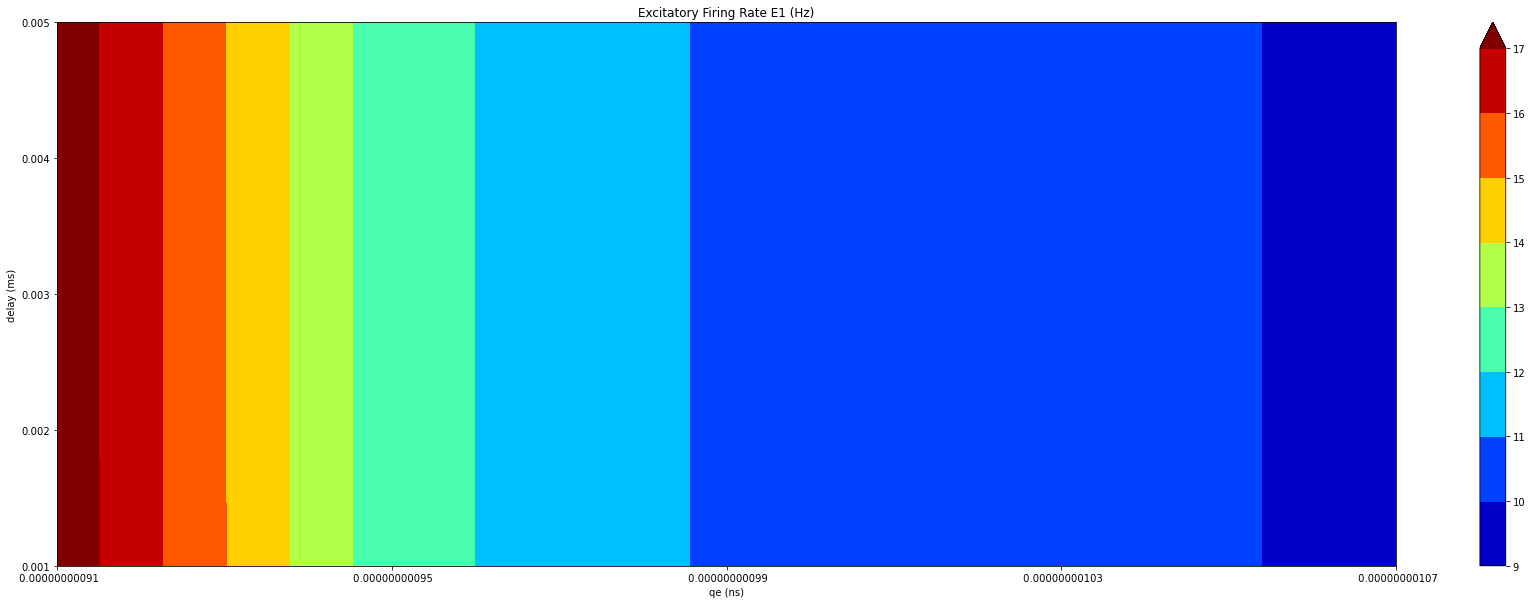

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.contourf(np.transpose(firing_rate), cmap='jet',extend='max')
plt.yticks(np.arange(0,len(delays),1), delays)
plt.xticks(np.arange(0,len(qes),1), [f"{qe: .11f}" for qe in qes])
plt.colorbar()
#plt.xlim(9.1e-9,1.1e-9)
plt.xlabel("qe (ns)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate E1 (Hz)")
plt.show()

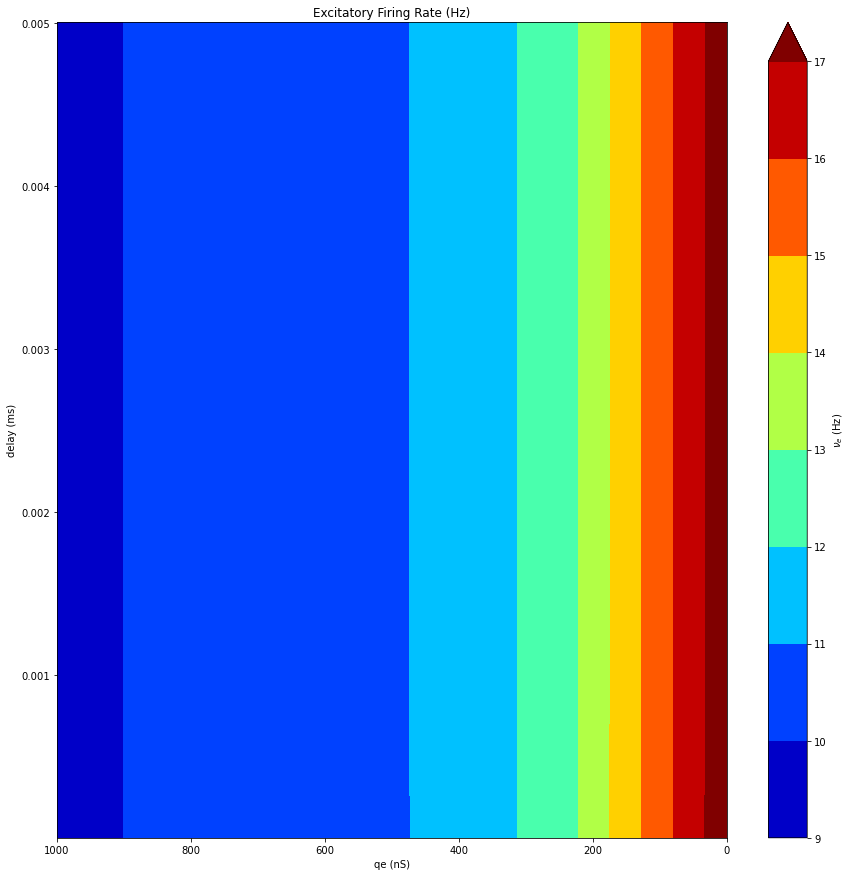

In [91]:
from scipy.interpolate import interp2d
f = interp2d(qes,delays,firing_rate.reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.contourf(Z,
           cmap='jet',
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower", extend='max')
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
#plt.xticks(np.arange(200,len(qes) * 100 ,200), [f"{qe: .11f}" for qe in qes if int(qe * 1e9)%2 == 0])
cbar=plt.colorbar()
plt.xlim(1000,0)
cbar.set_label('$\\nu_e$ (Hz)')
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (Hz)")
plt.show()

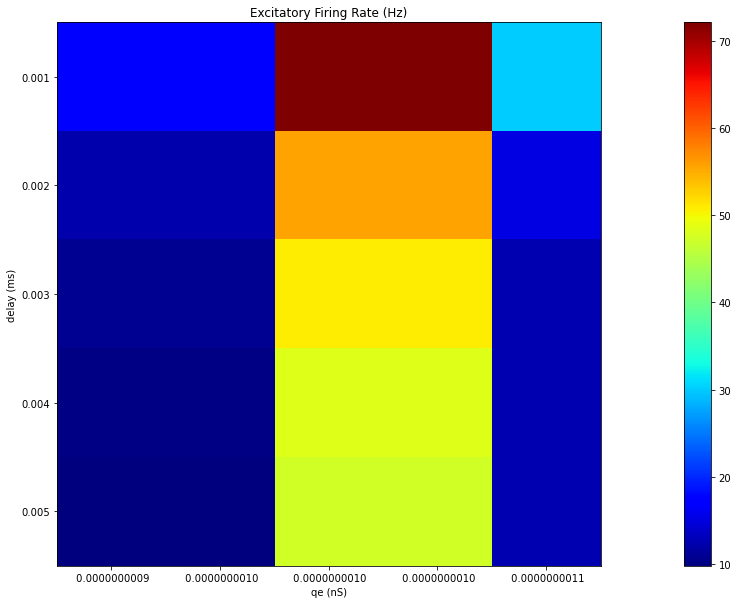

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 10))
plt.imshow(fr_b1_1ns, cmap='jet', interpolation='nearest')
plt.yticks(np.arange(0,len(delays),1), delays)
plt.xticks(np.arange(0,len(qes),1), [f"{qe: .10f}" for qe in qes])
plt.colorbar()
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (Hz)")
plt.show()

In [59]:
qes=np.arange(1e-1,1,1e-1)

In [33]:
f=np.load('final_state_b=1_qe=0.0000000011_delay=0.002.npy')

In [34]:
f

array([1.23330250e-01, 1.23330249e-01, 1.90665831e+00, 1.90665834e+00,
       3.06007196e-03, 1.35440354e-03, 5.69157527e-03, 6.94843811e-03,
       1.35440354e-03, 3.06007193e-03, 6.94843802e-03, 5.69157519e-03,
       5.69157527e-03, 6.94843802e-03, 5.00822204e-02, 2.31087076e-02,
       6.94843811e-03, 5.69157519e-03, 2.31087076e-02, 5.00822205e-02,
       1.27791631e-13, 1.27791623e-13])

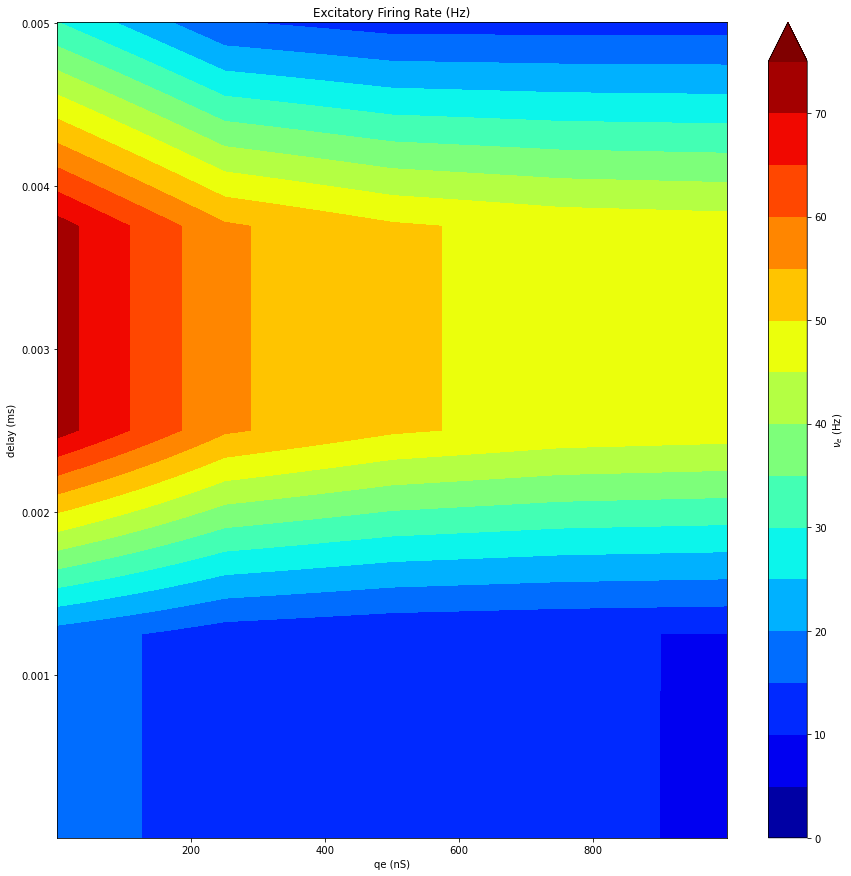

In [51]:
from scipy.interpolate import interp2d
f = interp2d(qes,delays,fr_b1_1ns.reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.contourf(Z,
           cmap='jet',
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower", extend='max',levels=np.arange(0,80,5))
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
#plt.xticks(np.arange(200,len(qes) * 100 ,200), [f"{qe: .11f}" for qe in qes if int(qe * 1e9)%2 == 0])
cbar=plt.colorbar()
#plt.xlim(1000,0)
cbar.set_label('$\\nu_e$ (Hz)')
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (Hz)")
plt.show()

In [246]:
np.save('firing_rate_b=1pA.npy',firing_rate)

In [57]:
fr_b1=np.load('firing_rate_b=1pA.npy')

In [247]:
params['b']=[20e-12,20e-12,0,0] # b 

In [202]:
np.arange(9.2e-10,1.3e-9,8e-11)

array([9.20e-10, 1.00e-09, 1.08e-09, 1.16e-09, 1.24e-09])

In [255]:
np.arange(8.2e-10,1.2e-9,4e-11)

array([8.20e-10, 8.60e-10, 9.00e-10, 9.40e-10, 9.80e-10, 1.02e-09,
       1.06e-09, 1.10e-09, 1.14e-09, 1.18e-09])

In [248]:
exciatory_firing_rates = []
delays = np.arange(1e-3,6e-3,1e-3)
qes = np.arange(9.2e-10,1.3e-9,8e-11)#max 1.2e-9 à 8.2e-10 np.arange(9.2e-10,1.2e-9,8e-11)
for delay in delays:
    for j, qe in enumerate(qes):
        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delay
        params['delays'][1][0]=delay
        params['delays'][2][1]=delay
        params['delays'][3][0]=delay

        x0=final_state.copy()
        x0[0]+=0.5
        x0[1]+=0.5
        #t_trace=[]
        x_trace_RS=[]
        #TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=max_delay

        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            #t_trace.append(time)
            x_trace_RS.append(x0.copy())
            #TF_trace_RS.append(TF_inst.copy())
        final_state=x_trace_RS[-1]
        np.save(f'final_state_b=20_qe={qe:.10f}_delay={delay:.3f}.npy',final_state)
        x_transp=np.transpose(x_trace_RS)
        exciatory_firing_rates.append(np.max(x_transp[j+steps, steps+1:])*10)

#############################################
 
 
 sim1 : delay =  0.001  qe =  0.1  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  0.2  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  0.30000000000000004  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  0.4  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  0.5  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  0.6  
 



i =  1.5 



In [249]:
firing_rate = np.array(exciatory_firing_rates).reshape((len(delays),len(qes)))

In [ ]:
np.save('firing_rate_b=20pA_12ns.npy',firing_rate)

In [ ]:
fr_20_12ns=np.load('firing_rate_b=1pA_12ns.npy')

In [251]:
np.save('firing_rate_b=20pA.npy',firing_rate)

In [24]:
fr_b20=np.load('firing_rate_b=20pA.npy')

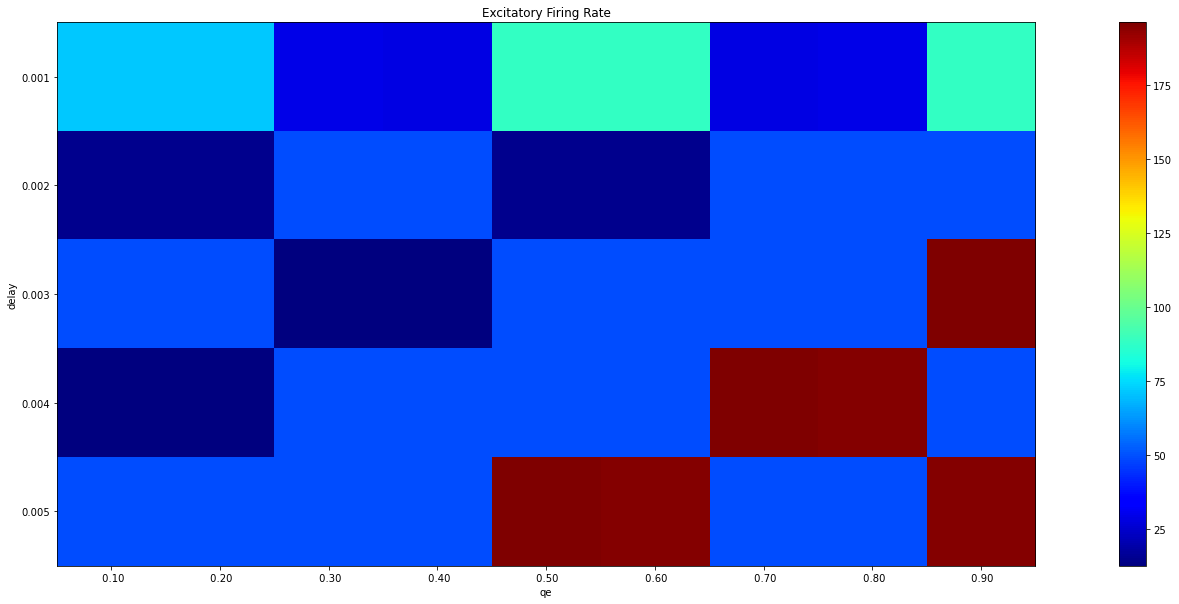

In [27]:
plt.figure(figsize=(30, 10))
plt.imshow(firing_rate, cmap='jet', interpolation='nearest')
plt.yticks(np.arange(0,len(delays),1), delays)
plt.xticks(np.arange(0,len(qes),1), [f"{qe: .2f}" for qe in qes])
plt.colorbar()
plt.xlabel("qe")
plt.ylabel("delay")
plt.title("Excitatory Firing Rate")
plt.show()

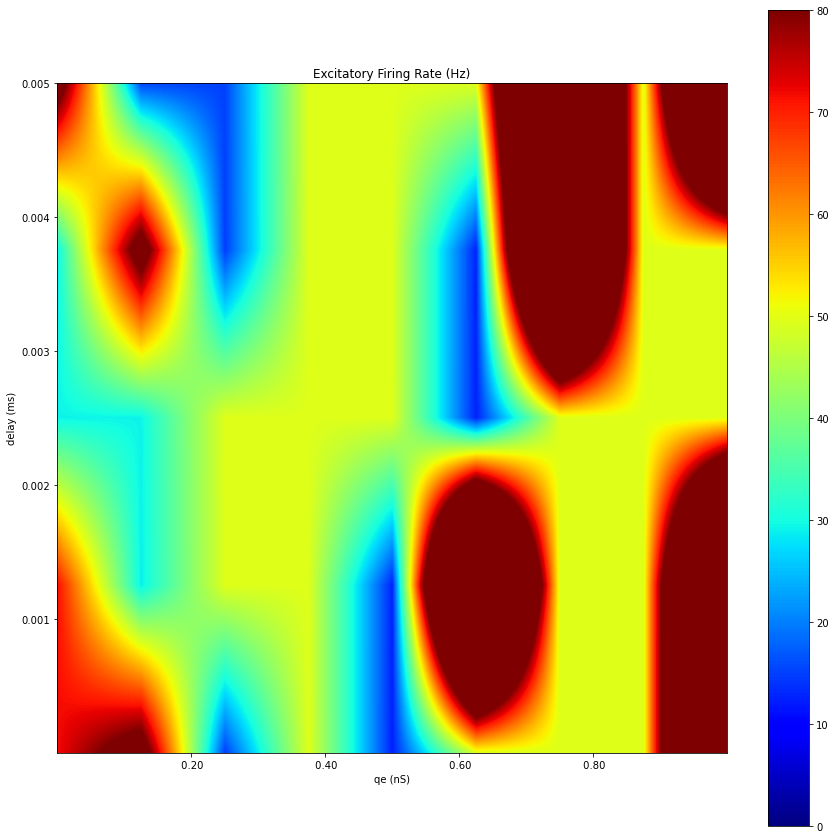

In [28]:
f = interp2d(qes,delays,fr_b20.reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.imshow(Z,
           cmap='jet', 
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower",vmin=0, vmax=80)
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
plt.xticks(np.arange(200,len(qes) * 100 ,200), [f"{qe: .2f}" for qe in qes if int(qe * 10)%2 == 0])
plt.colorbar()
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (Hz)")
plt.show()

In [ ]:
f = interp2d(qes,delays,fr_b20.reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.imshow(Z,
           cmap='jet', 
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower",vmin=0, vmax=80)
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
plt.xticks(np.arange(200,len(qes) * 100 ,200), [f"{qe: .10f}" for qe in qes if int(qe * 1e9)%2 == 0])
cbar=plt.colorbar()
cbar.set_title('$\\nu_e$ (Hz)')
plt.xlim=(1000,0)
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (Hz)")
plt.show()

In [254]:
params['b']=[40e-12,40e-12,0,0] # b 

In [200]:
np.arange(9.3e-10,1.35e-9,9e-11)

array([9.30e-10, 1.02e-09, 1.11e-09, 1.20e-09, 1.29e-09])

In [286]:
exciatory_firing_rates = []
delays = np.arange(1e-3,6e-3,1e-3)
qes = np.arange(9.3e-9,1.3e-9,4e-11)#np.arange(9.3e-10,1.35e-9,9e-11)
for delay in delays:
    for j, qe in enumerate(qes):
        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delay
        params['delays'][1][0]=delay
        params['delays'][2][1]=delay
        params['delays'][3][0]=delay

        x0=final_state.copy()
        x0[0]+=0.5
        x0[1]+=0.5
        #t_trace=[]
        x_trace_RS=[]
        #TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=max_delay

        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            #t_trace.append(time)
            x_trace_RS.append(x0.copy())
            #TF_trace_RS.append(TF_inst.copy())
        final_state=x_trace_RS[-1]
        np.save(f'final_state_b=40_qe={qe:.2f}_delay={delay:.3f}.npy',final_state)
        x_transp=np.transpose(x_trace_RS)
        exciatory_firing_rates.append(np.max(x_transp[min(j+ 2 * steps, 21), steps+1:])*10)

#############################################
 
 
 sim1 : delay =  0.005  qe =  0.7  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  0.8999999999999999  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 



In [290]:
firing_rate = np.array(exciatory_firing_rates).reshape((len(delays),len(qes)))

In [ ]:
np.save('firing_rate_b=40pA_14ns.npy',firing_rate)

In [ ]:
fr_40_14ns=np.load('firing_rate_b=20pA_12ns.npy')

In [293]:
np.save('firing_rate_b=40pA.npy',firing_rate)

In [29]:
fr_40=np.load('firing_rate_b=40pA.npy')

In [33]:
qes=np.arange(1e-1,1,2e-1)

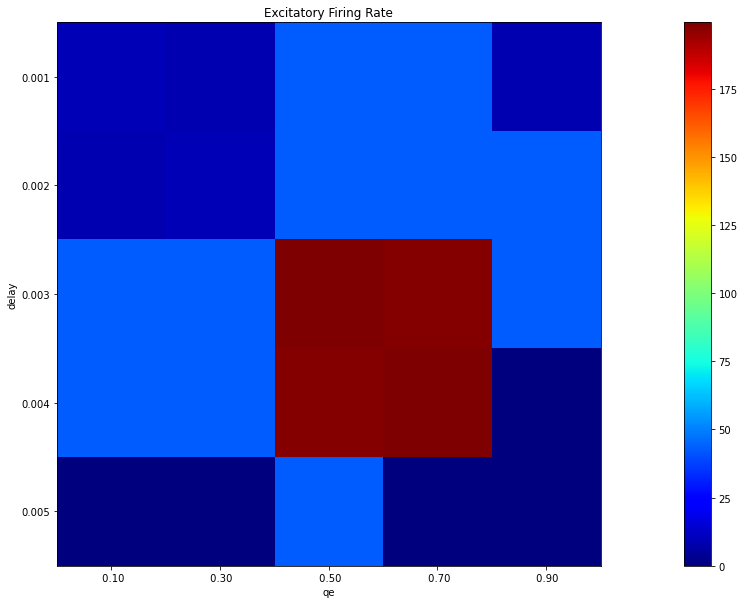

In [34]:
plt.figure(figsize=(30, 10))
plt.imshow(fr_40_14ns, cmap='jet', interpolation='nearest')
plt.yticks(np.arange(0,len(delays),1), delays)
plt.xticks(np.arange(0,len(qes),1), [f"{qe: .2f}" for qe in qes])
plt.colorbar()
plt.xlabel("qe")
plt.ylabel("delay")
plt.title("Excitatory Firing Rate")
plt.show()

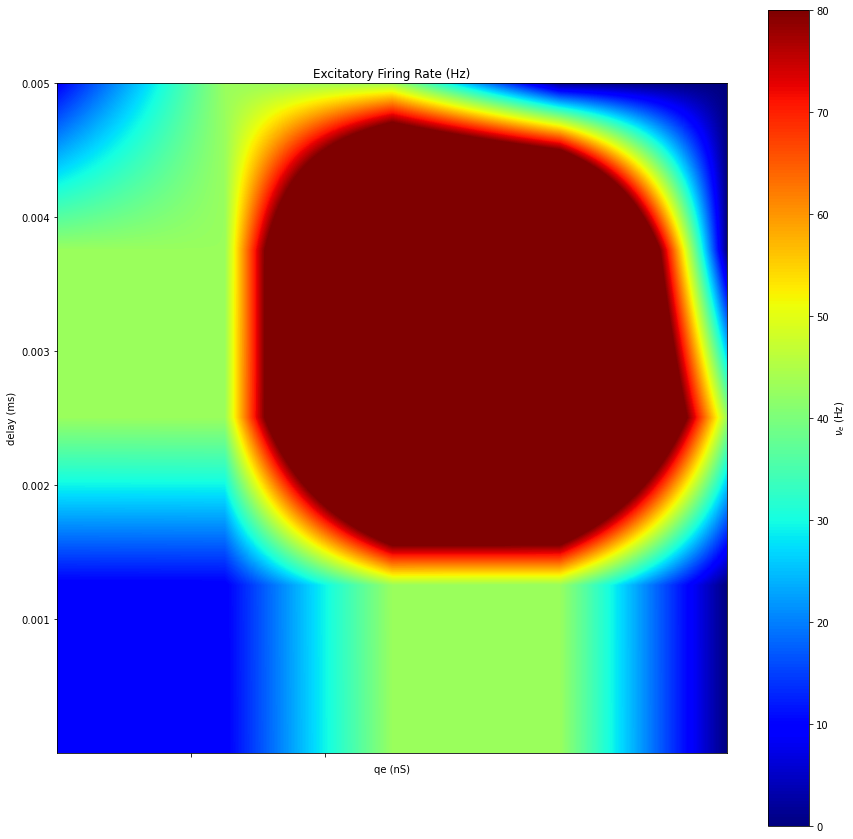

In [54]:
f = interp2d(qes,delays,fr_40.reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.imshow(Z,
           cmap='jet', 
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower",vmin=0, vmax=80)
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
plt.xticks(np.arange(200,len(qes) * 100 ,200), [f"{qe: .2f}" for qe in qes if int(qe * 10)%2 == 0])
cbar=plt.colorbar()
cbar.set_label('$\\nu_e$ (Hz)')
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (Hz)")
plt.show()

In [7]:
params['b']=[60e-12,60e-12,0,0] # b 

In [195]:
np.arange(1.1e-9,1.5e-9,9e-11)

array([1.10e-09, 1.19e-09, 1.28e-09, 1.37e-09, 1.46e-09])

In [10]:
exciatory_firing_rates = []
delays = np.arange(1e-3,6e-3,1e-3)
qes = np.arange(1e-9,1.5e-9,5e-11) #np.arange(1.1e-9,1.5e-9,9e-11) deconne à 1.5e-9 et min a 1e-9
for delay in delays:
    for j, qe in enumerate(qes):
        np.random.seed(10)
        print('#############################################')
        print(' \n \n sim1 : delay = ', delay,' qe = ',qe,' \n \n')
        print('#############################################')
        ''' DEFINE THE INPUT FUNCTION '''
        params['qe']=qe
        params['delays'][0][1]=delay
        params['delays'][1][0]=delay
        params['delays'][2][1]=delay
        params['delays'][3][0]=delay

        x0=final_state.copy()
        x0[0]+=0.5
        x0[1]+=0.5
        #t_trace=[]
        x_trace_RS=[]
        #TF_trace_RS=[]

        x_trace_RS.append(x0.copy())    

        #for i in range(steps):x_trace_RS.append(x0.copy())
        #print(delay)
        #delays[0][1]=delays[3][0]=delays[1][0]=delays[2][1]=0.005
        ###########################################
        ###########################################

##################### INITIATE THE PAST COORDINANTES ##########################
        delay_matrix=np.matrix(delay)
        max_delay=delay_matrix.max()

#### Associated number of time steps ####

        steps=int(max_delay/params['tstep'])

        for i in range(steps):x_trace_RS.append(x0.copy())

##################################################################################

        #print(x0)
        #print(params['delays'])
        time=max_delay

        for i in np.arange(0,2,params['tstep']):
            params['x_hist']=np.transpose(x_trace_RS)
            TF_inst=Euler_method_General(x0,params,time,MeanField_dN_dp_delay)
            if (i%0.5==0):print('i = ', i, '\n')
            time+=params['tstep']
            #t_trace.append(time)
            x_trace_RS.append(x0.copy())
            #TF_trace_RS.append(TF_inst.copy())
        final_state=x_trace_RS[-1]
        np.save(f'final_state_b=60_qe={qe:.9f}_delay={delay:.3f}.npy',final_state)
        x_transp=np.transpose(x_trace_RS)
        exciatory_firing_rates.append(np.max(x_transp[min(j+3* steps, 21), steps+1:])*10)

#############################################
 
 
 sim1 : delay =  0.001  qe =  1e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.1000000000000001e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.2000000000000002e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.3000000000000003e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.001  qe =  1.4000000000000003e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

###########################

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  1.2000000000000002e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  1.3000000000000003e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  1.4000000000000003e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  1.5000000000000004e-09  
 

#############################################
i =  0.0 

i =  0.5 

i =  1.0 

i =  1.5 

#############################################
 
 
 sim1 : delay =  0.005  qe =  1.6000000000000005e-09  
 

#############################################
i =  0.0 

i =  0.5 


In [25]:
delays = np.arange(1e-3,6e-3,1e-3)
qes = np.arange(1e-1,1,1e-1)

In [11]:
firing_rate = np.array(exciatory_firing_rates).reshape((len(delays),len(qes)))

In [308]:
np.save('firing_rate_b=60pA.npy',firing_rate)

In [15]:
np.save('firing_rate_b=60pA_new.npy',firing_rate)

In [107]:
fr_60_23nS=np.load('firing_rate_b=60pA_new-2-3.npy')

In [12]:
np.save('firing_rate_b=60pA_new-1-2.npy',firing_rate)

In [4]:
fr_60_12ns=np.load('firing_rate_b=60pA_new-1-2.npy')

In [37]:
fr_60=np.load('firing_rate_b=60pA.npy')

In [5]:
qes=np.arange(1e-9,2e-9,1e-10)

In [73]:
np.arange(1e-9,2e-9,1e-10).shape

(10,)

In [6]:
delays=np.arange(1e-3,6e-3,1e-3)

In [298]:
np.arange(1,len(qes)*6,2)

array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33,
       35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59])

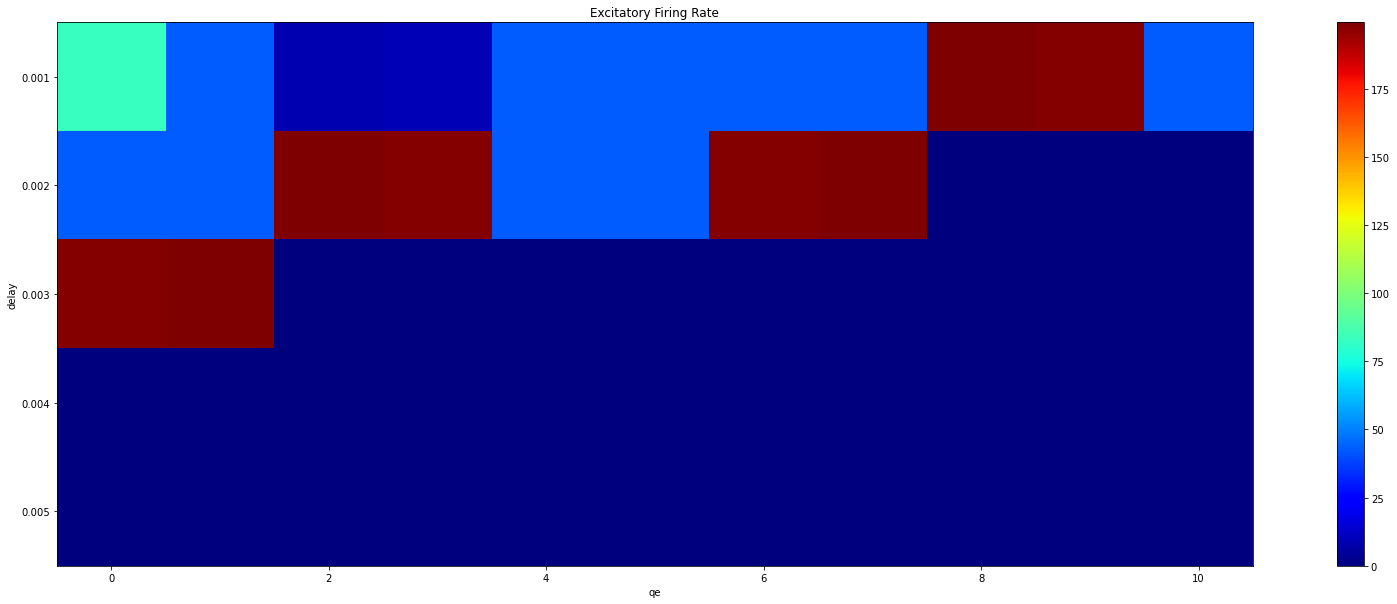

In [114]:
plt.figure(figsize=(30, 10))
plt.imshow(fr_60_23nS, cmap='jet', interpolation='nearest')
plt.yticks(np.arange(0,len(delays),1), delays)
#plt.xticks(np.arange(2,len(qes),3.1), [f"{qe: .10f}" for qe in qes])
plt.colorbar()
plt.xlabel("qe")
plt.ylabel("delay")
plt.title("Excitatory Firing Rate")
plt.show()

In [8]:
from scipy.interpolate import interp2d

In [96]:
np.arange(200,len(qes) * 105 ,200)

array([ 200,  400,  600,  800, 1000])

In [92]:
qes=np.arange(1e-9,2e-9,1e-10)

In [93]:
delays=np.arange(1e-3,6e-3,1e-3)

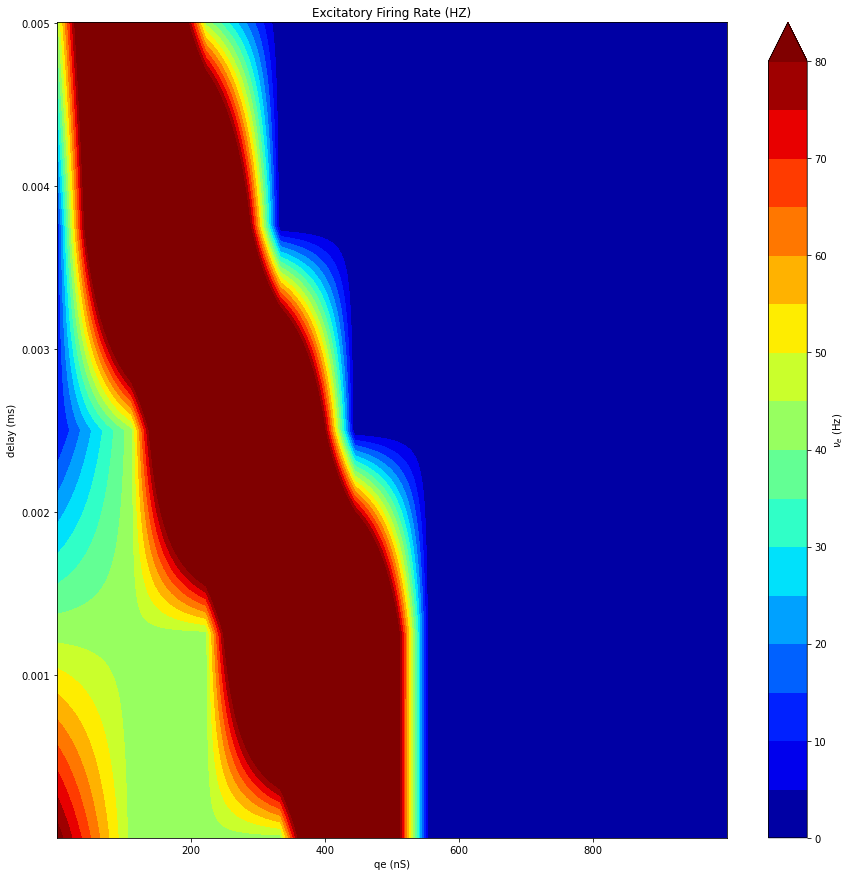

In [11]:
f = interp2d(qes,delays,fr_60_12ns.reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.contourf(Z,
           cmap='jet', 
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower",extend='max',levels=np.arange(0,85,5) )
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
#plt.xticks(np.arange(200,len(qes) * 105 ,200),[f"{qe: .9f}" for qe in qes if int(qe * 1e9)%2 == 0])
cbar=plt.colorbar()
cbar.set_label('$\\nu_e$ (Hz)')
#plt.xlim(1000,0)
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (HZ)")
plt.show()

In [133]:
import matplotlib.pylab as plt

In [135]:
qes=np.arange(2e-9,3e-9,1e-10)

In [125]:
fr_60_23nS[:,:-1].shape

(5, 10)

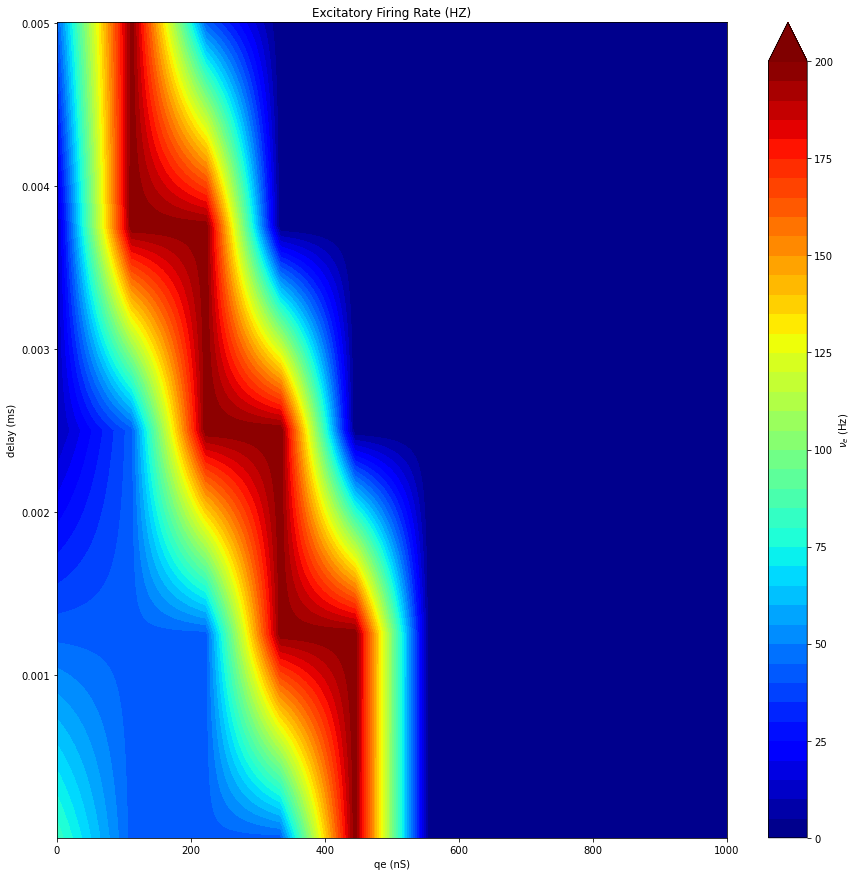

In [136]:
f = interp2d(qes,delays,fr_60_23nS[:,:-1].reshape(-1),kind="linear")
x_coords = np.arange(min(qes),max(qes), (-min(qes)+ max(qes)) / 1000)
y_coords = np.arange(min(delays),max(delays), (-min(delays)+ max(delays)) / 1000)
Z = f(x_coords,y_coords)
plt.figure(figsize=(15, 15))
plt.contourf(Z,
           cmap='jet', 
           #extent=[min(qes),max(qes),min(delays),max(delays)],
           origin="lower",extend='max',levels=np.arange(0,205,5) )
plt.yticks(np.arange(200,len(delays)*200 + 1,200), delays)
#plt.xticks(np.arange(200,len(qes) * 10 ,200),[f"{qe: .9f}" for qe in qes if int(qe * 1e9)%2 == 0])
cbar=plt.colorbar()
cbar.set_label('$\\nu_e$ (Hz)')
plt.xlim(0,1000)
plt.xlabel("qe (nS)")
plt.ylabel("delay (ms)")
plt.title("Excitatory Firing Rate (HZ)")
plt.show()